# Influence of Priors: Popularity Data

**Authors**: original R Tutorial created by Laurent Smeets and Rens van de Schoot, with updates by Duco Veen; Python translation by Florian Metwaly.

## Introduction

**This is part 2 of a 3 part series on how to do multilevel models in the Bayesian framework. In part 1 we explained how to step by step build the multilevel model we will use here and in part 3 we will look at the influence of different priors.**

## Preparation

This tutorial expects:

-  Basic knowledge of multilevel analyses (first two chapters of the book are sufficient).
-  Basic knowledge of coding in Python, and some familiarity with the R [LME4 package](https://www.rensvandeschoot.com/tutorials/lme4/).
-  Basic knowledge of Bayesian Statistics.
- Installation of bambi Python library
- Basic knowledge of [Bayesian](https://www.rensvandeschoot.com/a-gentle-introduction-to-bayesian-analysis-applications-to-developmental-research/) inference


## Priors

*"Prior specifications are flexible and explicitly encourage users to apply prior distributions that actually reflect their beliefs."* ([BRMS](https://cran.r-project.org/web/packages/brms/brms.pdf) manual)

We will set 4 types of extra priors here (in addition to the uninformative prior we have used thus far)
1.  With an estimate far off the value we found in the data with uninformative priors with a wide variance
2.  With an estimate close to the value we found in the data with uninformative priors with a small variance
3.  With an estimate far off the value we found in the data with uninformative priors with a small variance (1).
4.  With an estimate far off the value we found in the data with uninformative priors with a small variance (2).

In this tutorial we will only focus on priors for the regression coefficients and not on the error and variance terms, since we are most likely to actually have information on the size and direction of a certain effect and less (but not completely) unlikely to have prior knowledge on the unexplained variances. You might have to play around a little bit with the controls of the `fit()` function and specifically the `target_accept` and `max_treedepth`. Thankfully bambi will tell you when to do so.

## Step 1: Setting up packages

The main package that is used for this analysis is [bambi](https://bambinos.github.io/bambi/). For more information and a tutorial on how to install these please have a look at: https://bambinos.github.io/bambi/. The bambi library is build on [PyMC](https://www.pymc.io/welcome.html). PyMC is a probabilistic programming library for Python, which implements many of the features of STAN. If you encounter performance issues, before installing bambi, install PyMC following their guide: https://www.pymc.io/projects/docs/en/stable/installation.html.

If you are using Google Colab, remove the `#` and run the following lines to install the needed libraries

In [ ]:
#!pip install bambi

After you have installed `bambi`, you need to load some more libraries that we need for this tutorial.

In [56]:
import bambi as bmb # BAyesian Model-Building Interface in Python
import arviz as az # Exploratory analysis of Bayesian models
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 1337

## Step 2: Downloading the data

The popularity dataset contains characteristics of pupils in different classes. The main goal of this tutorial is to find models and test hypotheses about the relation between these characteristics and the popularity of pupils (according to their classmates). To download the popularity data go to https://github.com/MirjamMoerbeek/Data_Sets_ML_book/blob/main/popular2.sav. We will use the .sav file which can be found in the SPSS folder. After downloading the data to your working directory you can open it with the `pandas` library using the `pd.read_spss()` command.

Alternatively, you can directly download them from GitHub into your workin directory using the following command (this also works well if you are on Google Colab!):

In [5]:
url = "https://github.com/MirjamMoerbeek/Data_Sets_ML_book/raw/main/popular2.sav"

# Download the file
with open("popular2.sav", "wb") as f:
    response = requests.get(url)
    response.raise_for_status()
    f.write(response.content)

In [6]:
popular2data = pd.read_spss("popular2.sav")

There are some variables in the dataset that we do not use, so we can select the variables we will use and have a look at the first few observations:

In [7]:
# We select just the variables we will use
popular2data = popular2data[["pupil", "class", "extrav", "sex", "texp", "popular"]]

# Display the first 6 observations
popular2data.head(6)

,pupil,class,extrav,sex,texp,popular
0,1.0,1.0,5.0,girl,24.0,6.3
1,2.0,1.0,7.0,boy,24.0,4.9
2,3.0,1.0,4.0,girl,24.0,5.3
3,4.0,1.0,3.0,girl,24.0,4.7
4,5.0,1.0,5.0,girl,24.0,6.0
5,6.0,1.0,4.0,boy,24.0,4.7


## The Effect of Priors

By building the model using the `model.build()` command, you can inspect the prior specification of the model without fitting the model.

In [31]:
# Step 1: Define the model (but don't fit yet!)
model = bmb.Model(
    "popular ~ sex + extrav + texp + extrav:texp + (1 + extrav | class)",
    data=popular2data,
    center_predictors=False
)

# Step 2: Build the model to resolve and assign default priors (this is still not fitting the model!)
model.build()

# Step 3: Inspect the priors
model

       Formula: popular ~ sex + extrav + texp + extrav:texp + (1 + extrav | class)
        Family: gaussian
          Link: mu = identity
  Observations: 2000
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 5.0764, sigma: 18.3381)
            sex ~ Normal(mu: 0.0, sigma: 6.9113)
            extrav ~ Normal(mu: 0.0, sigma: 2.738)
            texp ~ Normal(mu: 0.0, sigma: 0.5275)
            extrav:texp ~ Normal(mu: 0.0, sigma: 0.101)
        
        Group-level effects
            1|class ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 18.3381))
            extrav|class ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.738))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.3822)

For the first model with priors we just set normal priors for all regression coefficients, in reality many, many more prior distributions are possible. Bambi is build on PyMC, therefore all prior distributions implemented in PyMC are possible. For an overview, see the [PyMC website](https://www.pymc.io/projects/docs/en/stable/api/distributions.html).

In [32]:
priors = {
    "extrav": bmb.Prior("Normal", mu=-10, sigma=100),
    "extrav:texp": bmb.Prior("Normal", mu=10, sigma=100),
    "sex": bmb.Prior("Normal", mu=-5, sigma=100),
    "texp": bmb.Prior("Normal", mu=-5, sigma=100),
    "Intercept": bmb.Prior("Normal", mu=10, sigma=100)
}

In [72]:
model6 = bmb.Model(
    "popular ~ sex + extrav + texp + extrav:texp + (1 + extrav | class)",
    data=popular2data,
    center_predictors=False,
    priors=priors
)

fit_model6 = model6.fit(
    draws=2000,
    tune=1000,
    chains=2,
    random_seed=SEED,
    target_accept=0.97
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, sex, extrav, texp, extrav:texp, 1|class_sigma, 1|class_offset, extrav|class_sigma, extrav|class_offset]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 509 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


To see which priors were inserted, inspect the model object again

In [38]:
model6

       Formula: popular ~ sex + extrav + texp + extrav:texp + (1 + extrav | class)
        Family: gaussian
          Link: mu = identity
  Observations: 2000
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 10.0, sigma: 100.0)
            sex ~ Normal(mu: -5.0, sigma: 100.0)
            extrav ~ Normal(mu: -10.0, sigma: 100.0)
            texp ~ Normal(mu: -5.0, sigma: 100.0)
            extrav:texp ~ Normal(mu: 10.0, sigma: 100.0)
        
        Group-level effects
            1|class ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.4554))
            extrav|class ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.738))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.3822)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

After this model with uninformative priors, it's time to do the analysis with informative priors. Three models with different priors are tested and compared to investigate the influence of the construction of priors on the posterior distributions and therefore on the results in general.

In [48]:
# Define custom priors
priors2 = {
    "extrav": bmb.Prior("Normal", mu=0.8, sigma=0.1),
    "extrav:texp": bmb.Prior("Normal", mu=-0.025, sigma=0.1),
    "sex": bmb.Prior("Normal", mu=1.25, sigma=0.1),
    "texp": bmb.Prior("Normal", mu=0.23, sigma=0.1),
    "Intercept": bmb.Prior("Normal", mu=-1.21, sigma=0.1)
}

# Define model
model7 = bmb.Model(
    "popular ~ sex + extrav + texp + extrav:texp + (1 + extrav | class)",
    data=popular2data,
    center_predictors=False,
    priors=priors2
)

# Fit model
fit_model7 = model7.fit(
    draws=2000,
    tune=1000,
    chains=2,
    random_seed=SEED,
    target_accept=0.97
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, sex, extrav, texp, extrav:texp, 1|class_sigma, 1|class_offset, extrav|class_sigma, extrav|class_offset]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 145 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [49]:
az.summary(fit_model7)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.748,0.012,0.726,0.770,0.000,0.000,5073.0,3081.0,1.00
Intercept,-1.206,0.094,-1.376,-1.027,0.002,0.001,3017.0,3052.0,1.00
sex[girl],1.239,0.034,1.179,1.309,0.000,0.001,5249.0,2930.0,1.00
extrav,0.803,0.023,0.760,0.846,0.001,0.000,1930.0,2283.0,1.00
texp,0.226,0.008,0.212,0.241,0.000,0.000,2050.0,2630.0,1.00
...,...,...,...,...,...,...,...,...,...
extrav|class[96.0],0.011,0.029,-0.035,0.075,0.001,0.001,1629.0,995.0,1.01
extrav|class[97.0],0.008,0.027,-0.044,0.064,0.001,0.001,3336.0,1015.0,1.01
extrav|class[98.0],-0.004,0.027,-0.059,0.048,0.000,0.001,5112.0,1229.0,1.01
extrav|class[99.0],0.002,0.028,-0.054,0.057,0.000,0.001,5999.0,1643.0,1.01


In [71]:
# Define priors
priors3 = {
    "extrav": bmb.Prior("Normal", mu=-1, sigma=0.1),
    "extrav:texp": bmb.Prior("Normal", mu=3, sigma=1),
    "sex": bmb.Prior("Normal", mu=-3, sigma=1),
    "texp": bmb.Prior("Normal", mu=-3, sigma=1),
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5)
}

# Define the model
model8 = bmb.Model(
    "popular ~ sex + extrav + texp + extrav:texp + (1 + extrav | class)",
    data=popular2data,
    center_predictors=False,
    priors=priors
)

# Fit the model
fit_model8 = model8.fit(
    draws=2000,
    tune=1000,
    chains=2,
    random_seed=SEED,
    target_accept=0.97
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, sex, extrav, texp, extrav:texp, 1|class_sigma, 1|class_offset, extrav|class_sigma, extrav|class_offset]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 262 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [51]:
az.summary(fit_model8)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.748,0.012,0.725,0.771,0.000,0.000,6341.0,3005.0,1.00
Intercept,-1.203,0.251,-1.720,-0.781,0.007,0.004,1325.0,2048.0,1.00
sex[girl],1.239,0.037,1.170,1.310,0.000,0.001,5914.0,2899.0,1.00
extrav,0.803,0.037,0.736,0.873,0.001,0.001,2164.0,2359.0,1.00
texp,0.226,0.015,0.195,0.252,0.000,0.000,1327.0,2166.0,1.00
...,...,...,...,...,...,...,...,...,...
extrav|class[96.0],0.010,0.029,-0.042,0.070,0.001,0.001,1232.0,992.0,1.00
extrav|class[97.0],0.009,0.028,-0.043,0.067,0.001,0.001,1987.0,1421.0,1.01
extrav|class[98.0],-0.004,0.026,-0.059,0.045,0.000,0.001,4675.0,1472.0,1.00
extrav|class[99.0],0.001,0.028,-0.056,0.057,0.000,0.001,5873.0,1708.0,1.01


In [70]:
# Define priors
priors4 = {
    "extrav": bmb.Prior("Normal", mu=3, sigma=0.1),
    "extrav:texp": bmb.Prior("Normal", mu=-3, sigma=1),
    "sex": bmb.Prior("Normal", mu=3, sigma=1),
    "texp": bmb.Prior("Normal", mu=3, sigma=1),
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5)
}

# Define the model formula with a manually specified Intercept
model9 = bmb.Model(
    "popular ~ sex + extrav + texp + extrav:texp + (1 + extrav | class)",
    data=popular2data,
    center_predictors=False,
    priors=priors4
)

# Fit the model
fit_model9 = model9.fit(
    draws=2000,
    tune=1000,
    chains=2,
    random_seed=SEED,
    target_accept=0.97
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, sex, extrav, texp, extrav:texp, 1|class_sigma, 1|class_offset, extrav|class_sigma, extrav|class_offset]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 305 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [53]:
az.summary(fit_model9)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.756,0.012,0.733,0.779,0.000,0.000,6158.0,2797.0,1.0
Intercept,-2.706,0.242,-3.157,-2.251,0.003,0.003,5732.0,3347.0,1.0
sex[girl],1.225,0.037,1.161,1.300,0.000,0.001,8850.0,2696.0,1.0
extrav,1.120,0.049,1.031,1.212,0.001,0.001,1408.0,2106.0,1.0
texp,0.311,0.015,0.284,0.340,0.000,0.000,5656.0,3211.0,1.0
...,...,...,...,...,...,...,...,...,...
extrav|class[96.0],0.037,0.054,-0.064,0.139,0.001,0.001,4978.0,2816.0,1.0
extrav|class[97.0],0.013,0.056,-0.089,0.123,0.001,0.001,8568.0,2384.0,1.0
extrav|class[98.0],0.007,0.055,-0.102,0.109,0.001,0.001,6702.0,2607.0,1.0
extrav|class[99.0],0.008,0.057,-0.091,0.121,0.001,0.001,6660.0,3012.0,1.0


Comparing the last three models we see that for the first two models the prior specification does not really have a large influence on the results. However, for the final model with the highly informative priors that are far from the observed data, the priors do influence the posterior results. Because of the fairly large dataset, the priors are unlikely to have a large influence unless they are highly informative. Because we asked to save the prior in the last model (`"sample_prior = TRUE"`), we can now plot the difference between the prior and the posterior distribution of different parameters. In all cases, we see that the prior has a large influence on the posterior compared to the posterior estimates we arrived in earlier models.

C:\Users\fmetwaly\AppData\Local\anaconda3\envs\BayesEst\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


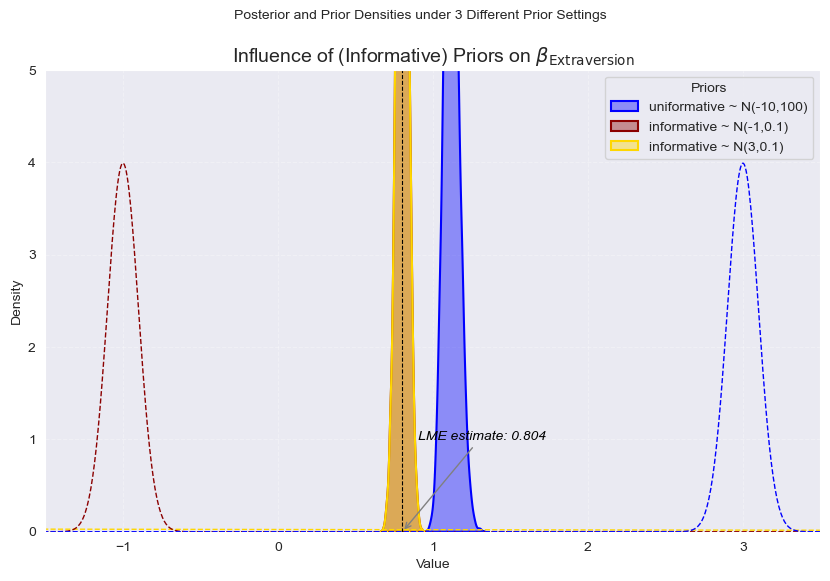

In [69]:
# 1. Extract posterior samples
def extract_posterior_samples(fit, param, label):
    samples = fit.posterior[param].values.flatten()
    return pd.DataFrame({"value": samples, "key": "posterior", "id": label})

# 2. Combine posteriors from each model
samples_6 = extract_posterior_samples(fit_model6, "extrav", "prior 1")
samples_8 = extract_posterior_samples(fit_model8, "extrav", "prior 2")
samples_9 = extract_posterior_samples(fit_model9, "extrav", "prior 3")

posterior_df = pd.concat([samples_6, samples_8, samples_9], ignore_index=True)

# 3. Get frequentist estimate
lme_model = MixedLM.from_formula("popular ~ sex + extrav + texp + extrav:texp",
                                 groups="class",
                                 re_formula="1 + extrav",
                                 data=popular2data)
lme_fit = lme_model.fit()
extrav_est = lme_fit.params["extrav"]

# 4. Plot posterior densities
plt.figure(figsize=(10, 6))
sns.kdeplot(data=posterior_df, x="value", hue="id", fill=True,
            alpha=0.4, linewidth=1.5, common_norm=False,
            palette=["gold", "darkred", "blue"],
            hue_order=["prior 1", "prior 2", "prior 3"])

# 5. Overlay analytical prior densities
x_vals = np.linspace(-2, 4, 1000)
priors = {
    "prior 1": norm.pdf(x_vals, loc=-10, scale=10),
    "prior 2": norm.pdf(x_vals, loc=-1, scale=0.1),
    "prior 3": norm.pdf(x_vals, loc=3, scale=0.1),
}
prior_colors = {"prior 1": "gold", "prior 2": "darkred", "prior 3": "blue"}

for label, y_vals in priors.items():
    plt.plot(x_vals, y_vals, label=f"{label} (prior)", color=prior_colors[label], linestyle="--", linewidth=1)

# 6. Add LME estimate
plt.axvline(extrav_est, color="black", linestyle="--", linewidth=0.8)
plt.annotate(f"LME estimate: {extrav_est:.3f}",
             xy=(extrav_est, 0), xytext=(extrav_est + 0.1, 1),
             arrowprops=dict(arrowstyle="->", color="gray"),
             fontsize=10, color="black", fontstyle="italic")

# 7. Final styling
plt.xlim(-1.5, 3.5)
plt.ylim(0, 5)
plt.xlabel("Value")
plt.title(r"Influence of (Informative) Priors on $\beta_{\mathrm{Extraversion}}$", fontsize=14)
plt.suptitle("Posterior and Prior Densities under 3 Different Prior Settings", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Priors", labels=[
    "uniformative ~ N(-10,100)",
    "informative ~ N(-1,0.1)",
    "informative ~ N(3,0.1)"
])
plt.show()


In this plot we can clearly see how the informative priors pull the posteriors towards them, while the uninformarive prior yields a posterior that is centred around what would be the frequentist (LME4) estimate.

#### Brms Reference

[Burkner, P. C. (2017). brms: An R package for Bayesian multilevel models using Stan. Journal of Statistical Software, 80(1), 1-28.](https://www.jstatsoft.org/article/view/v080i01)


## Original Computing Environment

In [ ]:
import session_info
session_info.show()